# Проверка корректности системы сплитования и проведение АА-теста 

У нас есть данные АА-теста с '2022-12-25' по '2022-12-31'. Вам нужно сделать симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации вам нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

In [19]:
### импортирую необходимые библиотеки

import pandahouse as ph
import pandas as pd
import seaborn as sns
from scipy import stats

In [2]:
# 1. Подключаюсь к БД

connection = {
                'host': 'https://clickhouse.lab.karpov.courses',
                'password': 'dpo_python_2020',
                'user': 'student',
                'database': 'simulator_20230120'
              }

In [3]:
# 2. Вывожу нужный датафрейм по датам и группам

query = """
        SELECT exp_group, 
            user_id,
            sum(action = 'like') as likes,
            sum(action = 'view') as views,
            likes/views as ctr
        FROM {db}.feed_actions 
        WHERE toDate(time) between '2022-12-25' and '2022-12-31'
            and exp_group in (2,3)
        GROUP BY exp_group, user_id
    """

df = ph.read_clickhouse(query, connection=connection)
df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667


In [4]:
### проверяю, одианковое ли количесвто пользователей в группах

df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


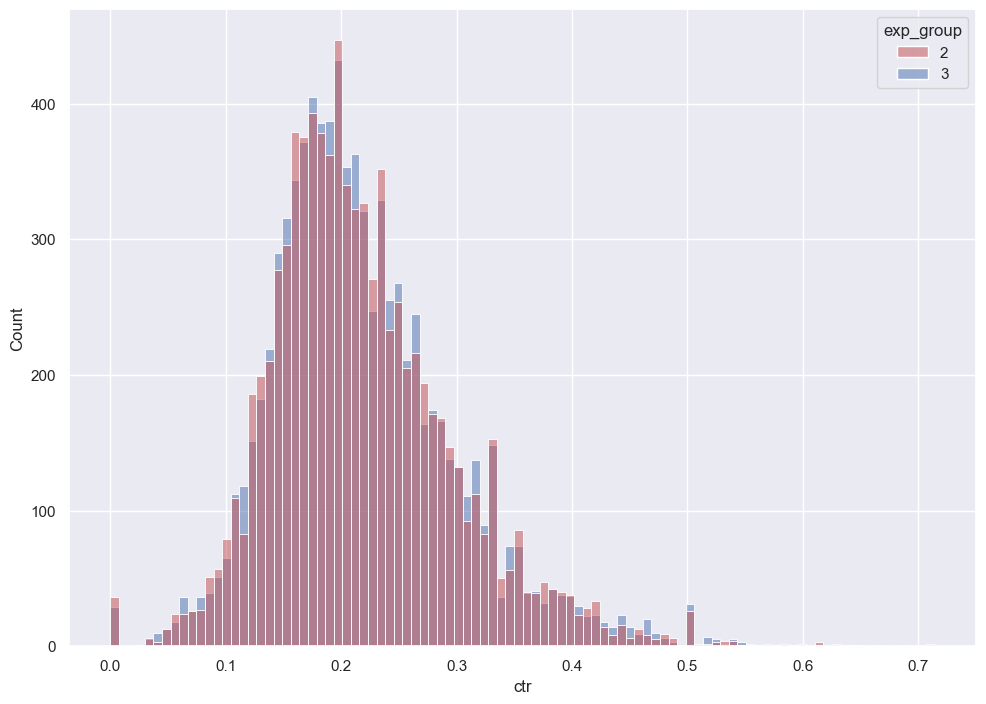

In [11]:
# 3. Строю гистограмму по ctr каждой группы, чтобы сравнить, одинаковое ли распределение (просто сумма ctr с одинаковым значением наносится на гистограмму).

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,         
              kde=False)

#### делаю гистограмму побольше

sns.set(rc={'figure.figsize':(10, 7)})

Распределение выглядит нормальным с небольшими выбросами и визуально обе группы похожи. Перехожу к проверке t-тестом.

In [7]:
# 4. Создаю отдельный дф для каждой группы 

df_g2 = df[df.exp_group == 2]
df_g3 = df[df.exp_group == 3]

In [8]:
# 5. Провожу t-тест 10000 раз с выборками по 500 юзаеров 

### задаю количество итераций и случайных подвыборок 
iterations = 10000
samples = 500

### пустой массив для p-values
p_values = []
### пишу цикл для массива
for i in range(iterations):
### беру df.sample - Return a random sample of items from an axis of object. 
    df_g2_ctr = df_g2.ctr.sample(samples, replace=False) ### replace=False - отключает повторение
    df_g3_ctr = df_g3.ctr.sample(samples, replace=False) 
### провожу t-тест    
    t_test = stats.ttest_ind(df_g2_ctr, df_g3_ctr, equal_var=False)[1]
### забираю из цикла p-value и добавляю в массив
    p_values.append(t_test)  
p_values = pd.Series(p_values)

p_values

0       0.903765
1       0.345779
2       0.273651
3       0.593070
4       0.612375
          ...   
9995    0.137441
9996    0.814617
9997    0.596682
9998    0.336510
9999    0.078056
Length: 10000, dtype: float64

<AxesSubplot:ylabel='Count'>

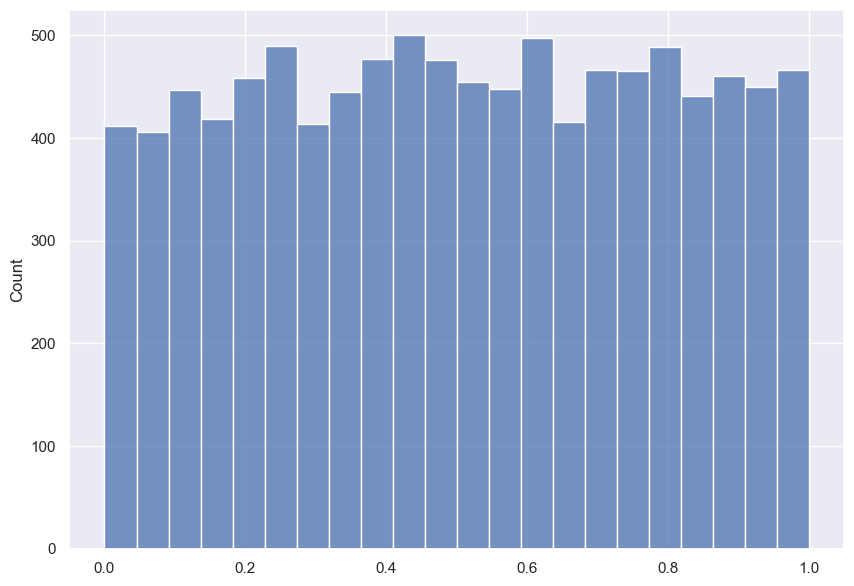

In [12]:
# 6. Вывожу все данные на гистограмму 

sns.histplot(p_values)

Все p-values распределены почти равномерно, значит результаты теста не показывают статистически значимых различий между двумя группами.

In [10]:
# 7. Считаю, какой процент p_values оказался меньше либо равен 0.05

p_values_below = round(p_values[p_values <= 0.05].count() / p_values.count() * 100, 2)
p_values_below

4.47

In [18]:
# 8. Пишу вывод

print('Система сплитования работает корреткно, потому что при проведении 10000 раз АА теста, распределение p-уровней значимости меньше 0,05 получилось в {}% случаях. Можно двигаться дальше и проводить AB тест'.format(p_values_below))

Система сплитования работает корреткно, потому что при проведении 10000 раз АА теста, распределение p-уровней значимости меньше 0,05 получилось в 4.47% случаях. Можно двигаться дальше и проводить AB тест
